### Load data

/var/folders/t8/0vpf6dyn0q111yjvx8dbs7dc0000gn/T/ipykernel_27899/418003038.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.mean())


SR Evidence          0.638889
bias_highbaserate    0.409722
pre_map_change       0.819444
post_map_change      0.548611
twostep_planning     0.784722
dtype: float64
36

percent choices consistent with SR = 0.39655172413793105


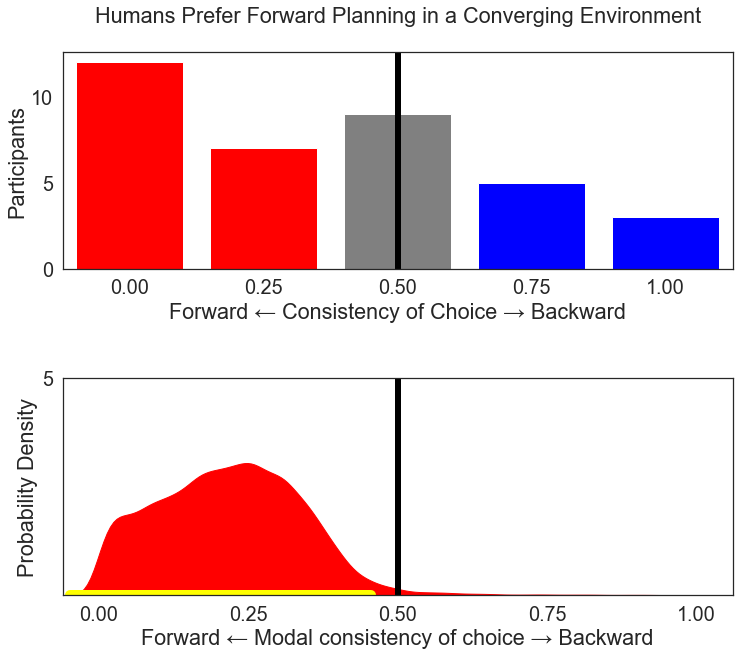

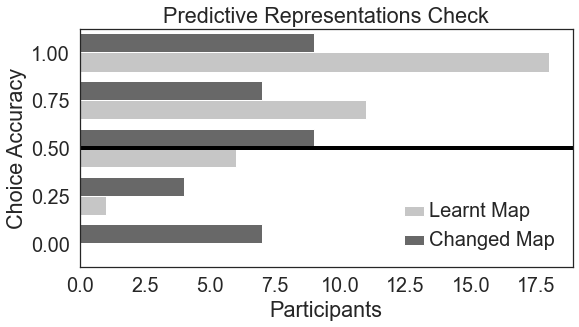

ROPE of PR EVIDENCE: 0.03297425643288393


In [11]:
# load dependencies
import numpy as np
from IPython.display import Image
from matplotlib import gridspec

import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure


import os

df=pd.read_csv('all_planning_questions_baseratebias.csv') #load data
#print means of each key variable
print(df.mean())
print(len(df))
n_subjects=len(df)
#Convert percentage of each key variable to number of successes out of 8 choices
#The purpose of this is to transform the data such that it can be modelled by a binomial likelihood
rr_map=round(df['pre_map_change']*4,2)
rr_map = rr_map.astype(int)

tr_changed_map=round(df['post_map_change']*4,2)
tr_changed_map = tr_changed_map.astype(int)

br_bias=round(df['bias_highbaserate']*4,2)
br_bias = br_bias.astype(int)

twostep_planning=round(df['twostep_planning']*4,2)
twostep_planning = twostep_planning.astype(int)
print('')

PR_evidence=round((1-df['SR Evidence'])*4,2)
PR_evidence = PR_evidence.astype(int)
SR_evidence=4-PR_evidence

print('percent choices consistent with SR = {}'.format(SR_evidence.sum()/(4*58)))

df['SR Evidence']=1-(df['SR Evidence'])
br_bias=df['bias_highbaserate']*4
# action_bias=df['bias_left_side']*8

sns.set(style='white', font='arial', font_scale=1.8, rc={'figure.figsize':(12,10)})


fig, axes = plt.subplots(2, 1)

x=sns.countplot(x="SR Evidence", palette='Blues',data=df,ax=axes[0],order = [x/4 for x in range(0,5)])

y=sns.kdeplot(data=df_posterior, x=('posterior', 'omega'),ax=axes[1],fill=True,alpha=1,color='red')
axes[0].set_ylabel('Participants')
axes[0].bar(df["SR Evidence"].unique()*4, df["SR Evidence"].value_counts(sort=False), color=['gray', 'red', 'red', 'blue', 'blue'])
axes[0].set_xlabel('Forward \u2190 Consistency of Choice \u2192 Backward')
axes[0].set_xlim(-0.5, 4.5)
# axes[0].xaxis.set_major_formatter('{x:.1f}')
axes[0].set_title('Humans Prefer Forward Planning in a Converging Environment\n')

axes[0].axvline(2,color='black',linewidth=6.0)
axes[1].set_xlim(-0.06,1.06)
axes[1].set_ylim
axes[1].set_ylabel('Probability Density')
axes[1].set_xlabel('Forward \u2190 Modal consistency of choice \u2192 Backward')
axes[1].axvline(0.5,color='black',linewidth=6.0)
axes[1].axhline(y=0,xmin=0.01,xmax=0.46,color='yellow',linewidth=10.0)
plt.sca(axes[1])
plt.yticks([5])
plt.xticks([0,0.25,0.5,0.75,1])
axes[0].margins(x=0)
axes[1].margins(x=0)
axes[0].set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in axes[0].get_xticklabels()])

# axes[1].set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in axes[1].get_xticklabels()])

fig.subplots_adjust(hspace=0.5)


plt.savefig('study3_PRevidence.png',dpi=300)

plt.show()

sns.set(style='white', font='arial', font_scale=1.8, rc={'figure.figsize':(8.5,5)})
fig, ax = plt.subplots()
#sigmoid function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


#load data
df_new=pd.DataFrame()
df_new['Revaluation Score']=df['pre_map_change'].values.tolist()+df['post_map_change'].values.tolist()
df_new['']=['Learnt Map']*len(df)+['Changed Map']*len(df)                              
#plot transition revaluation performance

ax=sns.countplot(data=df_new, y="Revaluation Score",hue="",palette='Greys',orient='v')
plt.xlabel('Participants')

ax.set_ylim(-0.5,4.5)
ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])

plt.axhline(2,color='black',linewidth=4.0)
sns.move_legend(ax, "lower right",frameon=False)

# Change the font size of the legend text
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_fontsize(20)

# Change the size and spacing of the legend bars
for patch in leg.get_patches():
    patch.set_height(10)
    patch.set_width(20)
    patch.set_x(patch.get_x() + 30) # adjust the y position of the bars


# for tick in ax.get_xaxis().get_major_ticks():
#     tick.set_pad(8.)

plt.ylabel('Choice Accuracy')
plt.title('Predictive Representations Check')

plt.tight_layout()

plt.savefig('study3_tr_Reval.png',dpi=300)
plt.show()
# Print 0.1*SD of PR Evidence to define the ROPE
print('ROPE of PR EVIDENCE: {}'.format(0.1*df['SR Evidence'].std()))


# Fit Model for Hypothesis 1: Evidence for SR-based Planning

Below we fit the beta-binomial described in text to choice data for Variable 1, which defines the number of times participants chose in line with PR-based planning. If omega, the mode of the group distribution, is estimated to be significantly greater than 0.5 (no evidence of PR-based planning), then we conclude evidence for our main hypothesis.

We followed Kruschke’s (2014) guidelines to derive the ROPE, wherein we took the standard deviation of the percentage of times subjects chose in line with PR-based planning and multiplied this value by 0.1 , which was 0.18, and multiplied this by 0.1, to define effects that are too small to be considered significant. We then rounded this up to 0.2 to make it even a bit more conservative than Kruschke’s (2014) recommendation. We use this ROPE for all subsequent analyses.

Note below, we fit the same model to the two subsequent manipulation checks, except include different variables (specifically, variables 3 and 5 as described in the preregistration).

In [12]:
n_subjects = n_subjects
subjects= [*range(n_subjects)]
with pm.Model() as hierarchical_model:

    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 1.105125 , 0.1051249)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_subjects)


    y = pm.Binomial('y',n=4,p=theta[subjects], observed=PR_evidence) 
    
with hierarchical_model:
    trace_main = pm.sample(draws=4000, target_accept=0.9999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 173 seconds.


In [13]:
df_posterior=trace_main.to_dataframe()
df_posterior.to_csv('posterior_model.csv')

In [14]:
import arviz as az
az.summary(trace_main, ['omega'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.223,0.122,0.0,0.398,0.002,0.001,3404.0,4125.0,1.0


In [15]:
subjects= [*range(n_subjects)]

with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 1.105125 , 0.1051249)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_subjects)


    y = pm.Binomial('y',n=4,p=theta[subjects], observed=twostep_planning) 
with hierarchical_model:
    twostep_trace = pm.sample(draws=4000, target_accept=0.99,init='adapt_diag')


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 139 seconds.


In [16]:
import arviz as az
az.summary(twostep_trace,['omega'],hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.858,0.063,0.751,0.989,0.001,0.001,1931.0,4637.0,1.0


In [17]:
subjects= [*range(n_subjects)]

with pm.Model() as hierarchical_model:
    alpha = pm.Gamma('alpha', 1.105125 , 0.1051249)
    beta = pm.Gamma('beta', 1.105125 , 0.1051249)
    
    theta = pm.Beta('theta', alpha=alpha+1, beta=beta+1, shape=n_subjects)

    y = pm.Binomial('y',n=4,p=theta[subjects], observed=rr_map) 
    
with hierarchical_model:
    trace_pre_map = pm.sample(draws=4000, target_accept=0.99,init='adapt_diag')


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 183 seconds.


In [18]:
import arviz as az
mean_rr=trace_pre_map.posterior.alpha.values/(trace_pre_map.posterior.alpha.values+trace_pre_map.posterior.beta.values)
az.summary(mean_rr,hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.859,0.048,0.768,0.959,0.001,0.001,1588.0,3432.0,1.0


## Posterior distribution for group-level tendency to choose in line with PR-based planning

As you see below, the parameter omega defining the group-level tendency to choose in line with PR-based planning was significantly greater than the null value of 0.5. Specifically, the posterior highest density interval does not contain any values in the pre-defined region of practical equivalence, defining values similar-enough to 0.5 to be considered null effect sizes. 

# Fit model for manipulation check 1: Bias for high base-rate action?

In [19]:
n_subjects = n_subjects
subjects= [*range(n_subjects)]
with pm.Model() as hierarchical_model:

    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 1.105125 , 0.1051249)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_subjects)


    y = pm.Binomial('y',n=4,p=theta[subjects], observed=br_bias) 
    
with hierarchical_model:
    trace = pm.sample(draws=4000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 108 seconds.


In [20]:
df_posterior_distal=trace.to_dataframe()

## Plot posterior for omega: The highest-density interval (yellow line) in the posterior
Manipulation check passed!

In [21]:
az.summary(trace, ['omega'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.401,0.051,0.304,0.496,0.001,0.001,3590.0,7088.0,1.0


/var/folders/t8/0vpf6dyn0q111yjvx8dbs7dc0000gn/T/ipykernel_27899/2482814080.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])


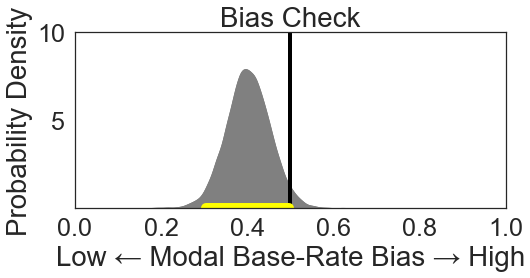

In [27]:
sns.set(style='white', font='arial', font_scale=2.3, rc={'figure.figsize':(8,4.5)})
fig, ax = plt.subplots()

x=sns.kdeplot(data=df_posterior_distal, x=('posterior', 'omega'),fill=True,alpha=1,color="gray")

y=sns.kdeplot(data=df_posterior_distal, x=('posterior', 'omega'),fill=True,alpha=1,color="gray")
ax.set_ylabel('Probability Density')
ax.set_xlabel('Low \u2190 Modal Base-Rate Bias \u2192 High')
ax.set_xlim(0,1.0)
ax.set_yticks([5,10])

ax.axvline(0.5,color='black',linewidth=4.0)

ax.set_title('Bias Check')
ax.axhline(y=0,xmin=0.304,xmax=0.496,color='yellow',linewidth=10.0)



ax.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])

plt.tight_layout()

plt.savefig('study3_action_baseratebias.png',dpi=300)
plt.show()

# Performance post map change

In [23]:
subjects= [*range(n_subjects)]

with pm.Model() as hierarchical_model:
    alpha = pm.Gamma('alpha', 1.01 , 0.01)
    beta = pm.Gamma('beta', 1.01 , 0.01)
    
    theta = pm.Beta('theta', alpha=alpha+1, beta=beta+1, shape=n_subjects)

    y = pm.Binomial('y',n=4,p=theta[subjects], observed=tr_changed_map) 
    
with hierarchical_model:
    trace_changed_map = pm.sample(draws=4000, target_accept=0.99,init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 404 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3698 divergences after tuning. Increase `target_accept` or reparameterize.


In [24]:
import arviz as az
mean_tr=(trace_changed_map.posterior.alpha.values)/(trace_changed_map.posterior.alpha.values+trace_changed_map.posterior.beta.values)
az.summary(mean_tr,hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.593,0.127,0.37,0.929,0.002,0.006,350.0,764.0,1.23


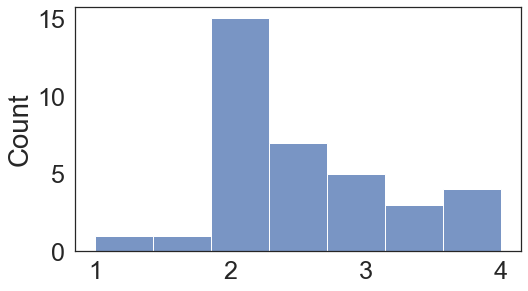

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 149 seconds.


In [25]:
difference_reval=(((rr_map-tr_changed_map))+4.0)/2.0
sns.histplot(difference_reval)
plt.show()
subjects= [*range(n_subjects)]

with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 1.105125 , 0.1051249)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_subjects)
    y = pm.Binomial('y',n=4,p=theta[subjects], observed=difference_reval) 
    
with hierarchical_model:
    diff_reval = pm.sample(draws=4000, target_accept=0.999,init='adapt_diag')

In [26]:
import arviz as az
# diff_tr=diff_reval.posterior.alpha.values/(diff_reval.posterior.alpha.values+diff_reval.posterior.beta.values)
az.summary(diff_reval,['omega'],hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.605,0.048,0.51,0.699,0.001,0.001,3420.0,6103.0,1.0


/Users/pbs44/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pbs44/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


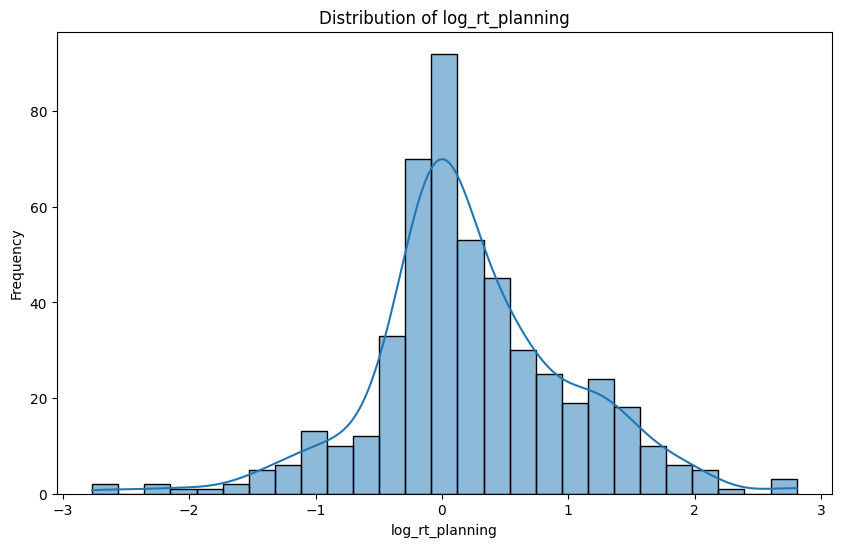

here
Pearson correlation between PR Evidence and log_rt_planning: 0.010004959755490497
Pearson correlation between MB Evidence and log_rt_planning: 0.0041266479555662
Pearson correlation between MB and PR Evidence: -0.24684283279701036


NameError: name 'llele' is not defined

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import bambi as bmb

# Load data
df = pd.read_csv('rts_planning_all_converging.csv')
# 1. Convert rt_planning to log_rt_planning
df['log_rt_planning'] = np.log(df['rt_planning_pr']/df['median_RT_actionselection'])
df = df[df['log_rt_planning']>-3]
# df = df[df['log_rt_planning']<3]

# 2. Plot log reaction times using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df['log_rt_planning'], kde=True)
plt.title('Distribution of log_rt_planning')
plt.xlabel('log_rt_planning')
plt.ylabel('Frequency')
plt.show()

print('here')
df['PR']=1-df['SR Evidence']
# 3. Calculate and print Pearson correlation
correlation, _ = stats.pearsonr(df['PR'], df['log_rt_planning'])
print(f'Pearson correlation between PR Evidence and log_rt_planning: {correlation}')
# 3. Calculate and print Pearson correlation
correlation, _ = stats.pearsonr(df['post_map_change'], df['log_rt_planning'])
print(f'Pearson correlation between MB Evidence and log_rt_planning: {correlation}')
correlation, _ = stats.pearsonr(df['post_map_change'], df['PR'])
print(f'Pearson correlation between MB and PR Evidence: {correlation}')

df['PR']=df['PR']-df['PR'].mean()/df['PR'].std()
df['MB']=df['post_map_change']-df['post_map_change'].mean()/df['post_map_change'].std()
df['BR']=df['bias_highbaserate']-df['bias_highbaserate'].mean()/df['bias_highbaserate'].std()
df.to_csv('rt_conv.csv')
llele
# 4. Hierarchical regression using Bambi
model2 = bmb.Model("log_rt_planning ~ PR_individual_answers+MB+BR+trial_num+(PR_individual_answers+trial_num|sub))", df)
fitted2 = model2.fit(draws=2000,target_accept=0.99)

In [3]:
import arviz as az
summary_df = az.summary(fitted2,var_names=['PR_individual_answers','MB','BR','trial_num'], hdi_prob=0.95)  # Exclude random effects conditioned on sub_id, consider 95% HDI
# Print the summary DataFrame
print(summary_df)

                        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
PR_individual_answers  0.173  0.083     0.011      0.341      0.001    0.001   
MB                    -0.003  0.167    -0.322      0.339      0.003    0.002   
BR                     0.093  0.278    -0.454      0.625      0.004    0.003   
trial_num             -0.101  0.020    -0.141     -0.064      0.000    0.000   

                       ess_bulk  ess_tail  r_hat  
PR_individual_answers    9332.0    6479.0    1.0  
MB                       3682.0    5291.0    1.0  
BR                       4911.0    5705.0    1.0  
trial_num               13259.0    5785.0    1.0  
